In [28]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import sklearn
from sklearn.model_selection import ParameterGrid

# Выборка
Датасет **MNIST** из http://yann.lecun.com/exdb/mnist/ содержит изображения рукописных цифр размером 28x28 пикселей.

## Множество ответов
Ответом служит цифра, то есть целочисленное значение от 0 до 9.

## Типы признаков
Датасет состоит из изображений 28х28, количество признаков 28 * 28 = 784, <br>
каждый из которых является яркостью сегмента и имеет целочисленное значение от 0 до 255.

## Визуализация данных

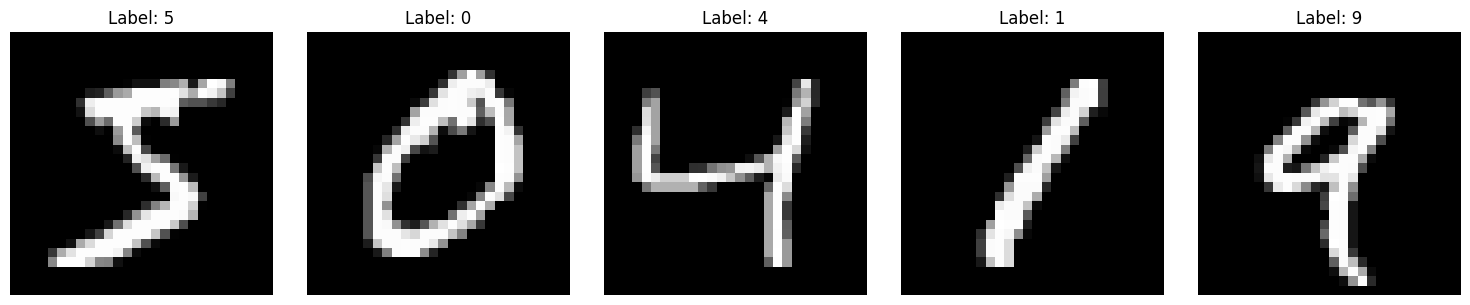

In [29]:
MNIST = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
train_loader_pytorch = torch.utils.data.DataLoader(MNIST, batch_size = 1, shuffle = False)

plt.figure(figsize=(15, 3))

for i, (image, label) in enumerate(train_loader_pytorch):
    if i < 5:
        plt.subplot(1, 5, i + 1)
        plt.imshow(image[0].squeeze(), cmap = 'gray')
        plt.title(f"Label: {label.item()}")
        plt.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

# Препроцессинг данных
60000 train/test данных занимает огромное количество времени. <br>
Выберем 3000 данных для train и 600 для test. 

In [30]:
from sklearn.model_selection import train_test_split

X_all = MNIST.data.view(-1, 28 * 28).numpy()
Y_all = MNIST.targets.numpy()

# Разделение на обучающую и тестовую выборки.
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, train_size = 0.05, test_size = 0.01)

print(len(X_train))
print(len(X_test))

3000
600


# Эксперимент для предложенных методов


In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score

Оптимизация гиперпараметров:

In [32]:
def opt_params(model, hyperparams, X_train, Y_train, cv):
    all_params = []
    
    for i, params in enumerate(hyperparams):
        # Прокидываем параметры в модель
        param_model = model(**params)

        # Считаем accuracy модели
        score = cross_val_score(param_model, X = X_train, y = Y_train, cv = cv, scoring = 'accuracy', n_jobs = 6).mean()
        all_params.append({'params': params, 'score': score})

    # Достаем лучшие параметры
    best_params = max(all_params, key = lambda x: x['score'])
    
    return best_params['params'], best_params['score']

Проверка модели:

In [33]:
def test_model(model, hyperparams, X_train, Y_train, X_test, Y_test):
    # Обучаем модель
    fit_model = model(**hyperparams).fit(X_train, Y_train)

    # Считаем accuracy модели на тестовой выборке
    Y_pred = fit_model.predict(X_test)
    return accuracy_score(Y_test, Y_pred)

## SVM

Описание модели:

In [34]:
from sklearn.svm import SVC

model = SVC

grid = ParameterGrid({
    'C': [5e-5, 1e-4, 1e-2],
    'gamma': [5e-5, 1e-4, 1e-2],
    'kernel': ['sigmoid', 'linear', 'poly']
})

Оптимизация гиперпараметров:

In [35]:
kfold_params, score = opt_params(model, grid, X_train, Y_train, KFold(n_splits = 10))
print("KFold:")
print(kfold_params)
print(score)

KFold:
{'C': 5e-05, 'gamma': 5e-05, 'kernel': 'poly'}
0.9196666666666665


In [36]:
strat_params, score = opt_params(model, grid, X_train, Y_train, StratifiedKFold(n_splits = 10))
print("StratifiedKFold:")
print(strat_params)
print(score)

StratifiedKFold:
{'C': 5e-05, 'gamma': 5e-05, 'kernel': 'poly'}
0.9216666666666666


Проверка модели:

In [37]:
accuracy = test_model(model, kfold_params, X_train, Y_train, X_test, Y_test)
print("KFold:")
print(accuracy)

KFold:
0.93


In [38]:
accuracy = test_model(model, strat_params, X_train, Y_train, X_test, Y_test)
print("StratifiedKFold:")
print(accuracy)

StratifiedKFold:
0.93


## Перцептрон

Описание модели:

In [39]:
from sklearn.linear_model import Perceptron

model = Perceptron

grid = ParameterGrid({
    'tol': [1e-5, 1e-3, 1e-1],
    'eta0': [1e-4, 1e-3, 1e-2, 1e-1],
    'penalty': ['l2', 'l1']
})

Оптимизация гиперпараметров:

In [40]:
kfold_params, score = opt_params(model, grid, X_train, Y_train, KFold(n_splits = 10))
print("KFold:")
print(kfold_params)
print(score)

KFold:
{'eta0': 0.01, 'penalty': 'l2', 'tol': 0.1}
0.8416666666666666


In [41]:
strat_params, score = opt_params(model, grid, X_train, Y_train, StratifiedKFold(n_splits = 10))
print("StratifiedKFold:")
print(strat_params)
print(score)

StratifiedKFold:
{'eta0': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.8416666666666666


Проверка модели:

In [42]:
accuracy = test_model(model, kfold_params, X_train, Y_train, X_test, Y_test)
print("KFold:")
print(accuracy)

KFold:
0.8566666666666667


In [43]:
accuracy = test_model(model, strat_params, X_train, Y_train, X_test, Y_test)
print("StratifiedKFold:")
print(accuracy)

StratifiedKFold:
0.84


## Метод Парзеновского окна

Описание модели:

In [44]:
from sklearn.base import BaseEstimator
from sklearn.neighbors import KernelDensity

class Parzen(BaseEstimator):
    def __init__(self, *, kernel = None, bandwidth = None):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.kde_models = {}

    def predict(self, X_test):
        scores = np.zeros((X_test.shape[0], 10))
        for i in range(10):
            # Оценка плотности для тестовых данных
            log_density = self.kde_models[i].score_samples(X_test)
            scores[:, i] = log_density

        # Предсказание цифры с максимальной оцененной плотностью
        Y_pred = np.argmax(scores, axis = 1)
        return Y_pred
        
    def fit(self, X_train, Y_train):
        for i in range(10):
            # Выбор данных для текущей цифры
            X_current = X_train[Y_train == i]
    
            # Обучение KDE
            kde = KernelDensity(kernel = self.kernel, bandwidth = self.bandwidth).fit(X_current)
            self.kde_models[i] = kde
            
        self.is_fitted_ = True
        return self

In [45]:
model = Parzen

grid = ParameterGrid({
    'bandwidth': [1e-3, 1e-2, 1e-1],
    'kernel': ['gaussian', 'tophat', 'exponential']
})

Оптимизация гиперпараметров:

In [46]:
kfold_params, score = opt_params(model, grid, X_train, Y_train, KFold(n_splits = 10))
print("KFold:")
print(kfold_params)
print(score)

KFold:
{'bandwidth': 0.01, 'kernel': 'gaussian'}
0.7583333333333333


In [47]:
strat_params, score = opt_params(model, grid, X_train, Y_train, StratifiedKFold(n_splits = 10))
print("StratifiedKFold:")
print(strat_params)
print(score)

StratifiedKFold:
{'bandwidth': 0.01, 'kernel': 'gaussian'}
0.7473333333333333


Проверка модели:

In [48]:
accuracy = test_model(model, kfold_params, X_train, Y_train, X_test, Y_test)
print("KFold:")
print(accuracy)

KFold:
0.7816666666666666


In [49]:
accuracy = test_model(model, strat_params, X_train, Y_train, X_test, Y_test)
print("StratifiedKFold:")
print(accuracy)

StratifiedKFold:
0.7816666666666666


# Анализ полученных результатов

## Общие сведения
- Обработка изображений рукописных цифр есть задача **многоклассовой классификации**. 
- **SVM** - метод, который эффективно работает с высокоразмерными данными, поэтому хорошо подходит для данной задачи.
- Рассмотрены методы классификации: **SVM**, **Перцептрон**, **Метод Парзеновского окна**
- Рассмотрены методы подбора гиперпараметров: **KFold** и **StratifiedKFold**.

## SVM
| Параметр                   | KFold | StratifiedKFold |
|----------------------------|:-----:|--------------|
| С                          |   5e-5   | 5e-5            |
| gamma                      |   1e-4   | 1e-4            |
| kernel                     |   poly   | poly            |
| accuracy                   |  0.93  | 0.93          |

## Перцептрон
| Параметр                   | KFold | StratifiedKFold |
|----------------------------|:-----:|--------------|
| eta0                          |   1e-2  | 1e-4            |
| tol                      |   1e-1   | 1e-5            |
| penaly                     |   l2   | l2            |
| accuracy                   |  0.86  | 0.84          |

## Метод Парзеновского окна
| Параметр                   | KFold | StratifiedKFold |
|----------------------------|:-----:|--------------|
| bandwidth                 |   1e-2   | 1e-2            |
| kernel                      |   gaussian   | gaussian            |
| accuracy                   |  0.78  | 0.78          |

## Проблемы

- Датасет оказался очень большим, поэтому пришлось его сократить, чтобы обучение происходило за разумное время.
- Пришлось реализовывать Метод Парзеновского окна, так как его нет в стандартных библиотеках.

## Итоги
- Самая точная модель на заданном датасете - **SVM**.
- Методы подбора гиперпараметров **KFold** и **StratifiedKFold** почти не отличаются по результатам.